<a href="https://colab.research.google.com/github/Dcodinginsane/Data-Analysis-project/blob/main/Geopandas1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### From GeoJSON to Network Graph: Analyzing World Country Borders in Python

In [5]:
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt


In [4]:
# Specify the path to your GeoJson file

geojson_file = '/content/countries.geojson'

# Read the GeoJSSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

gdf.head()

,ADMIN,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."


# GeoDataFrame contain the following columns
1. **ADMIN** - Represents the adminstravtve name of the geogrphical area, suchas the country or region name

2. ISO_A3: Stands for the ISO 3166–1 alpha-3 country code, a three-letter code uniquely identifying countries.
3. ISO_A2: Denotes the ISO 3166–1 alpha-2 country code, a two-letter code also used for country identification.
4. geometry: This column contains the geometrical information that defines the shape of the geographical area, represented as MULTIPOLYGON data


# Calculating Multipolygon Coordinates : Latitude and Longitude
the multi polygons within the geometry column belong to the class shapery.gemetry.multipolygon.Multipolygon


In [7]:
#  Calculate the centroid of each polygon and extract the latitude and longitude
gdf['centroid'] = gdf['geometry'].centroid
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

# Drop the centroid colum if you no longer need it
gdf = gdf.drop(columns=['centroid'])

<ipython-input-7-5559485a4868>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


# Creating a Country Border Network Graph

In [9]:
import networkx as nx
def create_country_network(gdf, country_column):
    """
    Create a network of neighboring countries based on their geometries and attributes.
    Parameters:
    gdf (geopandas.GeoDataFrame): A GeoDataFrame containing country geometries and attributes.
    country_column (str): The name of the column in the GeoDataFrame that contains country names.
    Returns:
    networkx.Graph: A NetworkX graph representing countries as nodes and neighboring relationships as edges.
    The function validates and cleans the input geometries, extracts latitude and longitude,
    adds countries as nodes to the graph, and adds edges between neighboring countries.

    """
    # Initialize a NetworkX graph
    G = nx.Graph()

    # Validate and clean geometries
    for idx, row in gdf.iterrows():
        country_name = row[country_column]
        geom = row['geometry']

        # Validate the geometry
        if not geom.is_valid:
            # Buffer with a very small distance to fix invalid geometries
            geom = geom.buffer(0)

        # Add the cleaned geometry back to the GeoDataFrame
        gdf.at[idx, 'geometry'] = geom

        # Extract latitude and longitude from the GeoDataFrame
        latitude = row['latitude']
        longitude = row['longitude']

        # Add the country as a node in the NetworkX graph with latitude and longitude as attributes
        G.add_node(country_name, latitude=latitude, longitude=longitude)

    # Add edges between neighboring countries
    for idx, row in gdf.iterrows():
        country1 = row[country_column]
        geom1 = row['geometry']

        for idx2, row2 in gdf.iterrows():
            if idx != idx2:
                country2 = row2[country_column]
                geom2 = row2['geometry']

                # Check if the cleaned geometries intersect
                if geom1.intersects(geom2):
                    G.add_edge(country1, country2)

    return G

# Create a network of neighboring countries based on the GeoDataFrame using the 'ADMIN' column
G = create_country_network(gdf, 'ADMIN')

# Visualizing the Constructed Network of Country Borders

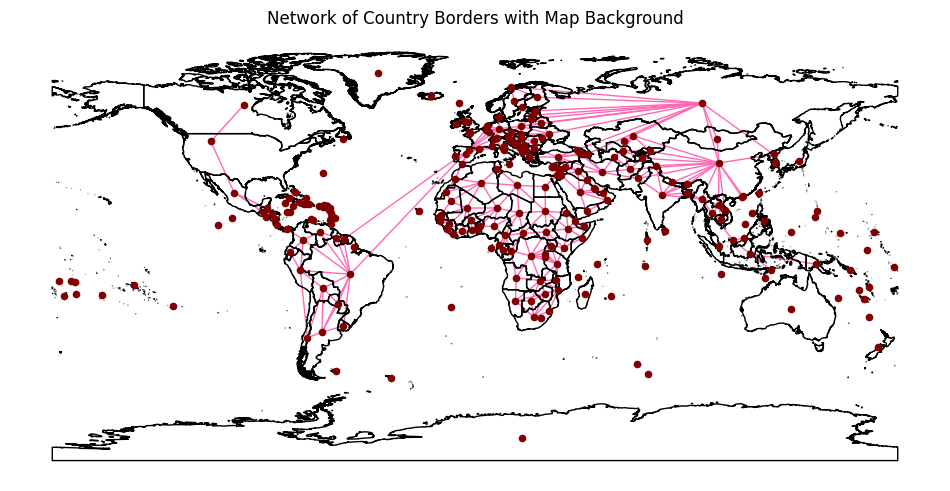

In [10]:
def plot_country_network_on_map(gdf, G):
    """
    Plot a network of neighboring countries on a map.
    Parameters:
    gdf (geopandas.GeoDataFrame): A GeoDataFrame containing country geometries and attributes.
    G (networkx.Graph): The network of neighboring countries.
    This function creates a plot with a background map, overlays the network of neighboring countries,
    and displays the result.
    """
    # Create a plot with a background map
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the country boundaries in black
    world = gdf.boundary.plot(ax=ax, linewidth=1, color='black')

    # Create a dictionary of node positions using longitude and latitude
    node_positions = {n: (d['longitude'], d['latitude']) for n, d in G.nodes(data=True)}

    # Draw the network on the map with specified node and edge attributes
    nx.draw(
        G,
        pos=node_positions,
        with_labels=False,  # Do not display node labels
        node_size=20,       # Set node size
        node_color='maroon',  # Set node color
        edge_color='hotpink',  # Set edge color
        ax=ax
    )

    # Set the plot title
    plt.title("Network of Country Borders with Map Background")

    # Turn off the axis labels and ticks
    plt.axis('off')

    # Display the plot
    plt.show()

# Call the function to plot the country network on a map
plot_country_network_on_map(gdf, G)

# Exploring Insights: Answering Questions with the Country Border Network


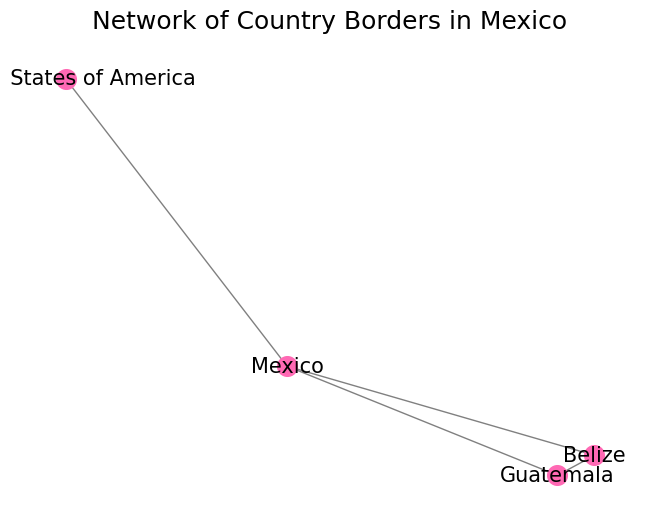

In [11]:
def plot_country_borders(G, country_name):
    """
    Plot the borders of a specified country and its neighboring countries on a map.
    Parameters:
    G (networkx.Graph): The network of neighboring countries.
    country_name (str): The name of the country to visualize.
    This function generates a subgraph containing the specified country and its neighboring countries,
    calculates node positions based on latitude and longitude, and visualizes the borders.
    """
    # Create a subgraph containing the specified country and its neighbors
    country_and_neighbors = [node for node in G.neighbors(country_name)] + [country_name]
    subgraph = G.subgraph(country_and_neighbors)

    # Calculate node positions using latitude and longitude
    node_positions = {n: (d['longitude'], d['latitude']) for n, d in subgraph.nodes(data=True)}

    # Visualize the subgraph with specified node and edge attributes
    nx.draw(
        subgraph,
        pos=node_positions,
        with_labels=True,
        node_size=200,
        font_size=15,
        node_color='hotpink',
        edge_color='gray',
    )

    # Set the plot title
    plt.title(f"Network of Country Borders in {country_name}", fontsize=18)

    # Turn off the axis labels and ticks
    plt.axis('off')

    # Display the plot
    plt.show()

# Call the function to plot the Mexico borders
plot_country_borders(G, 'Mexico')

# Insight 2: Top 10 Countries with the Most Borders

In [12]:
def calculate_top_border_countries(G, num_top_countries=10):
    """
    Calculate the number of neighboring countries for each country node in the network.
    Parameters:
    G (networkx.Graph): The network of neighboring countries.
    num_top_countries (int): The number of top countries to display.
    This function calculates the number of neighboring countries for each country node,
    sorts the countries by the number of borders in descending order, and prints the top countries.
    """
    border_counts = {}
    border_countries = {}

    # Calculate the number of neighboring countries for each country node
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        border_counts[node] = len(neighbors)
        border_countries[node] = neighbors

    # Sort the countries by the number of borders (in descending order)
    top_countries = sorted(border_counts.items(), key=lambda x: x[1], reverse=True)

    # Print the top countries with the most borders and their neighboring countries
    for i, (country, count) in enumerate(top_countries):
        if i < num_top_countries:
            neighbors = border_countries[country]
            print(f'{country} ({count} borders): {", ".join(neighbors)}')

# Calculate and display the top 10 countries with the most neighboring countries
calculate_top_border_countries(G, num_top_countries=10)

China (17 borders): Afghanistan, Bhutan, Hong Kong S.A.R., India, Siachen Glacier, Kazakhstan, Kyrgyzstan, Laos, Macao S.A.R, Myanmar, Mongolia, Nepal, Pakistan, North Korea, Russia, Tajikistan, Vietnam
Russia (14 borders): Azerbaijan, Belarus, China, Estonia, Finland, Georgia, Kazakhstan, Lithuania, Latvia, Mongolia, Norway, Poland, North Korea, Ukraine
Brazil (10 borders): Argentina, Bolivia, Colombia, France, Guyana, Peru, Paraguay, Suriname, Uruguay, Venezuela
France (10 borders): Andorra, Belgium, Brazil, Switzerland, Germany, Spain, Italy, Luxembourg, Monaco, Suriname
Democratic Republic of the Congo (9 borders): Angola, Burundi, Central African Republic, Republic of Congo, Rwanda, South Sudan, United Republic of Tanzania, Uganda, Zambia
Germany (9 borders): Austria, Belgium, Switzerland, Czech Republic, Denmark, France, Luxembourg, Netherlands, Poland
Austria (8 borders): Switzerland, Czech Republic, Germany, Hungary, Italy, Liechtenstein, Slovakia, Slovenia
Republic of Serbia (

# Insight 3: Exploring the Shortest Country-to-Country Routes

In [13]:

def find_shortest_path_between_countries(G, source_country, target_country):
    """
    Find and print the shortest path between two countries in the network.
    Parameters:
    G (networkx.Graph): The network of neighboring countries.
    source_country (str): The name of the source country.
    target_country (str): The name of the target country.
    This function finds the shortest path from the source country to the target country in the network,
    prints the minimum number of borders to cross, and displays the countries to traverse.
    """
    shortest_path = nx.shortest_path(G, source=source_country, target=target_country)

    # Print the minimum number of borders and the country names you have to cross
    print("Minimum number of borders to go from", source_country, "to", target_country, ":", len(shortest_path) - 1)
    print("Countries to cross:")
    for i in range(len(shortest_path) - 1):
        source = shortest_path[i]
        target = shortest_path[i + 1]
        print(f"{source} -> {target}")

# Find and print the shortest path from Spain to Poland in the network
find_shortest_path_between_countries(G, 'Spain', 'Poland')

Minimum number of borders to go from Spain to Poland : 3
Countries to cross:
Spain -> France
France -> Germany
Germany -> Poland
